In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.layers import (
    Conv2D, 
    Dense, 
    BatchNormalization, 
    Activation, 
    MaxPool2D, 
    GlobalAveragePooling2D, 
    Add, 
    Input, 
    Flatten, 
    LeakyReLU, 
    Concatenate, 
    Dropout,
    MaxPooling2D
)
from tensorflow.keras import Model, Sequential
from tensorflow.keras.constraints import Constraint ,UnitNorm
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import Orthogonal
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.losses import SparseCategoricalCrossentropy, KLDivergence
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from io import StringIO
import emnist as em
import re
import os

2023-01-13 14:00:54.789782: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/mmastalerczyk/opt/anaconda3/envs/umap2/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
tf.random.set_seed(1234)

## ResNet

In [3]:
# https://arxiv.org/pdf/1512.03385.pdf

In [4]:
def create_resnet(input_shape, class_count):
    n = 9 # 56 layers
    channels = [16, 32, 64]

    inputs = Input(shape=input_shape)
    x = Conv2D(channels[0], kernel_size=(3, 3), padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation(tf.nn.relu)(x)

    for c in channels:
        for i in range(n):
            subsampling = i == 0 and c > 16
            strides = (2, 2) if subsampling else (1, 1)
            y = Conv2D(c, kernel_size=(3, 3), padding="same", strides=strides, kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(x)
            y = BatchNormalization()(y)
            y = Activation(tf.nn.relu)(y)
            y = Conv2D(c, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(y)
            y = BatchNormalization()(y)        
            if subsampling:
                x = Conv2D(c, kernel_size=(1, 1), strides=(2, 2), padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(x)
            x = Add()([x, y])
            x = Activation(tf.nn.relu)(x)

    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    outputs = Dense(class_count, activation=tf.nn.softmax, kernel_initializer="he_normal")(x)

    return Model(inputs=inputs, outputs=outputs)

In [5]:
# PREPARE TRAINING
lr = 0.1
optimizer = SGD(learning_rate=lr, momentum=0.9)
import time


class LearningController(Callback):
    def __init__(self, num_epoch=0, learn_minute=0):
        self.num_epoch = num_epoch
        self.learn_second = learn_minute * 60
        if self.learn_second > 0:
            print("Leraning rate is controled by time.")
        elif self.num_epoch > 0:
            print("Leraning rate is controled by epoch.")
        
    def on_train_begin(self, logs=None):
        if self.learn_second > 0:
            self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        if self.learn_second > 0:
            current_time = time.time()
            if current_time - self.start_time > self.learn_second / 2:
                self.model.optimizer.lr = lr * 0.1            
            if current_time - self.start_time > self.learn_second * 3 / 4:
                self.model.optimizer.lr = lr * 0.01
                
        elif self.num_epoch > 0:
            if epoch > self.num_epoch / 2:
                self.model.optimizer.lr = lr * 0.1            
            if epoch > self.num_epoch * 3 / 4:
                self.model.optimizer.lr = lr * 0.01
                    
        print('lr:%.2e' % self.model.optimizer.lr.value())
        

learn_minute = 120

2023-01-13 20:54:17.342490: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dense NN

In [6]:
def create_dense_nn(input_shape, class_count):
    return Sequential(
        [
            Input(shape=input_shape),
            Flatten(),
            Dense(256),
            Dense(class_count),
        ],
    )

## Distiller class

In [7]:
class Distiller(Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [8]:
batch_size = 128
num_epoch = 192

## CIFAR-10

In [9]:
cifar = tfds.load('cifar10', as_supervised = True, batch_size = -1)
cifar_test, cifar_train = cifar['test'], cifar['train']

In [10]:
cifar_train_x = cifar_train[0].numpy() / 255
cifar_train_y = cifar_train[1].numpy()
cifar_test_x = cifar_test[0].numpy() / 255
cifar_test_y = cifar_test[1].numpy()

In [11]:
cifar_train_x, cifar_val_x, cifar_train_y, cifar_val_y = train_test_split(cifar_train_x, cifar_train_y, 
    test_size=0.25, random_state= 8)

## Teacher 

In [12]:
cifar_teacher_model = create_resnet((32, 32, 3), 10)
cifar_teacher_model.type = "cifar_resnet"
cifar_teacher_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 16)   0           ['batch_normalization[0][0]']

 rmalization)                                                                                     
                                                                                                  
 activation_9 (Activation)      (None, 32, 32, 16)   0           ['batch_normalization_9[0][0]']  
                                                                                                  
 conv2d_10 (Conv2D)             (None, 32, 32, 16)   2320        ['activation_9[0][0]']           
                                                                                                  
 batch_normalization_10 (BatchN  (None, 32, 32, 16)  64          ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_4 (Add)                    (None, 32, 32, 16)   0           ['activation_8[0][0]',           
          

                                                                                                  
 batch_normalization_19 (BatchN  (None, 16, 16, 32)  128         ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_19 (Activation)     (None, 16, 16, 32)   0           ['batch_normalization_19[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 16, 16, 32)   9248        ['activation_19[0][0]']          
                                                                                                  
 conv2d_21 (Conv2D)             (None, 16, 16, 32)   544         ['activation_18[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_28 (Activation)     (None, 16, 16, 32)   0           ['add_13[0][0]']                 
                                                                                                  
 conv2d_30 (Conv2D)             (None, 16, 16, 32)   9248        ['activation_28[0][0]']          
                                                                                                  
 batch_normalization_29 (BatchN  (None, 16, 16, 32)  128         ['conv2d_30[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_29 (Activation)     (None, 16, 16, 32)   0           ['batch_normalization_29[0][0]'] 
                                                                                                  
 conv2d_31

 ormalization)                                                                                    
                                                                                                  
 add_18 (Add)                   (None, 8, 8, 64)     0           ['conv2d_40[0][0]',              
                                                                  'batch_normalization_38[0][0]'] 
                                                                                                  
 activation_38 (Activation)     (None, 8, 8, 64)     0           ['add_18[0][0]']                 
                                                                                                  
 conv2d_41 (Conv2D)             (None, 8, 8, 64)     36928       ['activation_38[0][0]']          
                                                                                                  
 batch_normalization_39 (BatchN  (None, 8, 8, 64)    256         ['conv2d_41[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_48 (BatchN  (None, 8, 8, 64)    256         ['conv2d_50[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_23 (Add)                   (None, 8, 8, 64)     0           ['activation_46[0][0]',          
                                                                  'batch_normalization_48[0][0]'] 
                                                                                                  
 activation_48 (Activation)     (None, 8, 8, 64)     0           ['add_23[0][0]']                 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 8, 8, 64)     36928       ['activation_48[0][0]']          
          

In [13]:
cifar_teacher_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

cifar_teacher_path = "ResNet-for-CIFAR-10.h5"
cifar_teacher_checkpoint = ModelCheckpoint(filepath = cifar_teacher_path, monitor="val_loss", verbose=1, save_best_only=True)
cifar_teacher_learning_controller = LearningController(num_epoch)
cifar_teacher_callbacks = [cifar_teacher_checkpoint, cifar_teacher_learning_controller]

Leraning rate is controled by epoch.


Epoch 1/192
293/293 [==============================] - ETA: 0s - loss: 3.1918 - accuracy: 0.1179
Epoch 1: val_loss improved from inf to 2.88271, saving model to ResNet-for-CIFAR-10.h5
lr:1.00e-01
293/293 [==============================] - 39s 85ms/step - loss: 3.1918 - accuracy: 0.1179 - val_loss: 2.8827 - val_accuracy: 0.1491
Epoch 2/192
293/293 [==============================] - ETA: 0s - loss: 2.6052 - accuracy: 0.2416
Epoch 2: val_loss did not improve from 2.88271
lr:1.00e-01
293/293 [==============================] - 23s 79ms/step - loss: 2.6052 - accuracy: 0.2416 - val_loss: 5.2574 - val_accuracy: 0.1370
Epoch 3/192
293/293 [==============================] - ETA: 0s - loss: 2.3139 - accuracy: 0.3338
Epoch 3: val_loss improved from 2.88271 to 2.27426, saving model to ResNet-for-CIFAR-10.h5
lr:1.00e-01
293/293 [==============================] - 24s 81ms/step - loss: 2.3139 - accuracy: 0.3338 - val_loss: 2.2743 - val_accuracy: 0.3466
Epoch 4/192
293/293 [============================

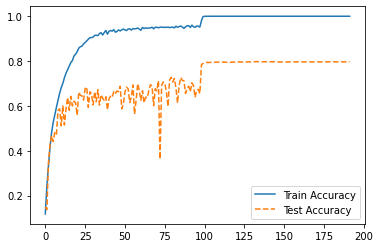

In [ ]:
# TRAIN

if os.path.isfile(cifar_teacher_path):
    cifar_teacher_model.load_weights(cifar_teacher_path)
else:
    cifar_history = cifar_teacher_model.fit(cifar_train_x, cifar_train_y,
                    batch_size=batch_size, 
                    epochs=num_epoch, 
                    validation_data=(cifar_val_x, cifar_val_y), 
                    verbose=1,                    
                    callbacks=cifar_teacher_callbacks)

    plt.plot(cifar_history.history["accuracy"], label = 'Train Accuracy')
    plt.plot(cifar_history.history["val_accuracy"], linestyle = 'dashed', label = 'Test Accuracy')
    plt.legend()
    plt.show()

In [ ]:
cifar_teacher_model.evaluate(cifar_test_x, cifar_test_y)

313/313 [==============================] - 3s 9ms/step - loss: 1.4134 - accuracy: 0.7887


[1.4133535623550415, 0.7886999845504761]

### Reduced Teacher

In [ ]:
cifar_reduced_teacher = create_dense_nn((32, 32, 3), 10)
cifar_reduced_teacher.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               786688    
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
Total params: 789,258
Trainable params: 789,258
Non-trainable params: 0
_________________________________________________________________


### CIFAR Teacher - Reduced Teacher Distillation

Epoch 1/20
1172/1172 [==============================] - 42s 31ms/step - sparse_categorical_accuracy: 0.9050 - student_loss: 1.5638 - distillation_loss: 0.0412 - val_sparse_categorical_accuracy: 0.7323 - val_student_loss: 1.6290
Epoch 2/20
1172/1172 [==============================] - 35s 30ms/step - sparse_categorical_accuracy: 0.9133 - student_loss: 1.5548 - distillation_loss: 0.0413 - val_sparse_categorical_accuracy: 0.7218 - val_student_loss: 1.7804
Epoch 3/20
1172/1172 [==============================] - 35s 30ms/step - sparse_categorical_accuracy: 0.9174 - student_loss: 1.5495 - distillation_loss: 0.0413 - val_sparse_categorical_accuracy: 0.7284 - val_student_loss: 1.6422
Epoch 4/20
1172/1172 [==============================] - 35s 30ms/step - sparse_categorical_accuracy: 0.9241 - student_loss: 1.5422 - distillation_loss: 0.0413 - val_sparse_categorical_accuracy: 0.7291 - val_student_loss: 1.7416
Epoch 5/20
1172/1172 [==============================] - 35s 30ms/step - sparse_categoric

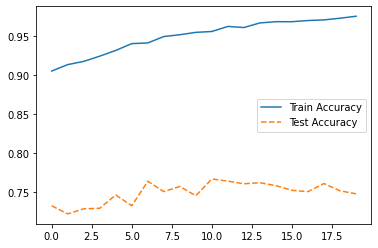

In [ ]:
cifar_distiller = Distiller(student=cifar_teacher_model, teacher=cifar_reduced_teacher)
cifar_distiller.compile(
    optimizer=Adam(),
    metrics=[SparseCategoricalAccuracy()],
    student_loss_fn=SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=KLDivergence(),
    alpha=0.2,
    temperature=3,
)

# Distill teacher to student
cifar_reduced_teacher_history = cifar_distiller.fit(cifar_train_x, cifar_train_y, validation_data=(cifar_val_x, cifar_val_y), epochs=20)

# Evaluate student on test dataset
cifar_distiller.evaluate(cifar_test_x, cifar_test_y)

plt.plot(cifar_reduced_teacher_history.history["sparse_categorical_accuracy"], label = 'Train Accuracy')
plt.plot(cifar_reduced_teacher_history.history["val_sparse_categorical_accuracy"], linestyle = 'dashed', label = 'Test Accuracy')
plt.legend()
plt.show()

## EMINIST

In [14]:
(emnist_train_x, emnist_train_y) = em.extract_training_samples('letters')
emnist_train_x, emnist_train_y = shuffle(emnist_train_x, emnist_train_y)
(emnist_test_x, emnist_test_y) = em.extract_test_samples('letters')
emnist_train_x = emnist_train_x.reshape((emnist_train_x.shape[0], 28, 28, 1))
emnist_test_x = emnist_test_x.reshape((emnist_test_x.shape[0], 28, 28, 1))

In [15]:
emnist_train_x = emnist_train_x.astype('float32')
emnist_test_x = emnist_test_x.astype('float32')
emnist_train_x = emnist_train_x / 255.0
emnist_test_x = emnist_test_x / 255.0

emnist_train_x, emnist_val_x, emnist_train_y, emnist_val_y = train_test_split(emnist_train_x, emnist_train_y, 
    test_size=0.25, random_state= 8)

### Teacher 

In [16]:
emnist_teacher_model = create_resnet((28, 28, 1), 27)
emnist_teacher_model.type = "emnist_resnet"

In [17]:
emnist_teacher_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

emnist_teacher_path = "ResNet-for-EMNIST.h5"
emnist_teacher_checkpoint = ModelCheckpoint(filepath = emnist_teacher_path, monitor="val_loss", verbose=1, save_best_only=True)
emnist_teacher_learning_controller = LearningController(num_epoch)
emnist_teacher_callbacks = [emnist_teacher_checkpoint, emnist_teacher_learning_controller]

Leraning rate is controled by epoch.


Epoch 1/192
732/732 [==============================] - ETA: 0s - loss: 1.9652 - accuracy: 0.5815
Epoch 1: val_loss improved from inf to 1.06250, saving model to ResNet-for-EMNIST.h5
lr:1.00e-03
732/732 [==============================] - 58s 70ms/step - loss: 1.9652 - accuracy: 0.5815 - val_loss: 1.0625 - val_accuracy: 0.8113
Epoch 2/192
731/732 [============================>.] - ETA: 0s - loss: 0.8749 - accuracy: 0.8648
Epoch 2: val_loss improved from 1.06250 to 0.82547, saving model to ResNet-for-EMNIST.h5
lr:1.00e-03
732/732 [==============================] - 49s 68ms/step - loss: 0.8749 - accuracy: 0.8647 - val_loss: 0.8255 - val_accuracy: 0.8765
Epoch 3/192
731/732 [============================>.] - ETA: 0s - loss: 0.7308 - accuracy: 0.9024
Epoch 3: val_loss improved from 0.82547 to 0.72353, saving model to ResNet-for-EMNIST.h5
lr:1.00e-03
732/732 [==============================] - 49s 67ms/step - loss: 0.7308 - accuracy: 0.9024 - val_loss: 0.7235 - val_accuracy: 0.9037
Epoch 4/192

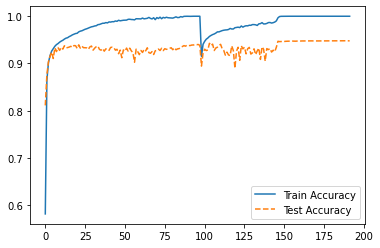

In [ ]:
# TRAIN

if os.path.isfile(emnist_teacher_path):
    emnist_teacher_model.load_weights(emnist_teacher_path)
else:
    emnist_history = emnist_teacher_model.fit(emnist_train_x, emnist_train_y, 
                    epochs=num_epoch, 
                    batch_size=batch_size, 
                    validation_data=(emnist_val_x, emnist_val_y), 
                    callbacks=emnist_teacher_callbacks,
          )


    plt.plot(emnist_history.history["accuracy"], label = 'Train Accuracy')
    plt.plot(emnist_history.history["val_accuracy"], linestyle = 'dashed', label = 'Test Accuracy')
    plt.legend()
    plt.show()

In [ ]:
emnist_teacher_model.evaluate(emnist_test_x, emnist_test_y)

650/650 [==============================] - 6s 9ms/step - loss: 0.4857 - accuracy: 0.9454


[0.48568499088287354, 0.9453846216201782]

### Reduced Teacher 

In [ ]:
emnist_reduced_teacher = create_dense_nn((28, 28, 1), 27)
emnist_reduced_teacher.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               200960    
                                                                 
 dense_5 (Dense)             (None, 27)                6939      
                                                                 
Total params: 207,899
Trainable params: 207,899
Non-trainable params: 0
_________________________________________________________________


### EMNIST Teacher - Reduced Teacher Distillation

Epoch 1/20
2925/2925 [==============================] - 83s 27ms/step - sparse_categorical_accuracy: 0.8943 - student_loss: 2.4677 - distillation_loss: 0.0176 - val_sparse_categorical_accuracy: 0.8904 - val_student_loss: 2.5423
Epoch 2/20
2925/2925 [==============================] - 77s 26ms/step - sparse_categorical_accuracy: 0.9148 - student_loss: 2.4451 - distillation_loss: 0.0176 - val_sparse_categorical_accuracy: 0.9210 - val_student_loss: 2.5649
Epoch 3/20
2925/2925 [==============================] - 78s 27ms/step - sparse_categorical_accuracy: 0.9216 - student_loss: 2.4374 - distillation_loss: 0.0176 - val_sparse_categorical_accuracy: 0.9114 - val_student_loss: 2.5430
Epoch 4/20
2925/2925 [==============================] - 77s 26ms/step - sparse_categorical_accuracy: 0.9272 - student_loss: 2.4316 - distillation_loss: 0.0176 - val_sparse_categorical_accuracy: 0.8925 - val_student_loss: 2.5730
Epoch 5/20
2925/2925 [==============================] - 77s 26ms/step - sparse_categoric

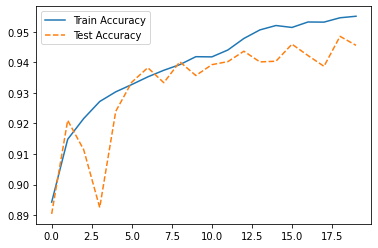

In [ ]:
emnist_distiller = Distiller(student=emnist_teacher_model, teacher=emnist_reduced_teacher)
emnist_distiller.compile(
    optimizer=Adam(),
    metrics=[SparseCategoricalAccuracy()],
    student_loss_fn=SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=KLDivergence(),
    alpha=0.2,
    temperature=3,
)

# Distill teacher to student
emnist_reduced_teacher_history = emnist_distiller.fit(emnist_train_x, emnist_train_y, validation_data=(emnist_val_x, emnist_val_y), epochs=20)

# Evaluate student on test dataset
emnist_distiller.evaluate(emnist_test_x, emnist_test_y)

plt.plot(emnist_reduced_teacher_history.history["sparse_categorical_accuracy"], label = 'Train Accuracy')
plt.plot(emnist_reduced_teacher_history.history["val_sparse_categorical_accuracy"], linestyle = 'dashed', label = 'Test Accuracy')
plt.legend()
plt.show()

# Part 3

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [ ]:
parameters = [
    ('gini', 3),
    ('gini', 5),
    ('gini', 10),
    ('entropy', 3),
    ('entropy', 5),
    ('entropy', 10),
]
seed = 1234

## CIFAR-10

In [ ]:
cifar_train_x.shape

(37500, 32, 32, 3)

In [ ]:
nsamples, nx, ny, dim = cifar_train_x.shape
dt_cifar_train_x = cifar_train_x.reshape((nsamples,nx*ny*dim))

nsamples, nx, ny, dim = cifar_val_x.shape
dt_cifar_val_x = cifar_val_x.reshape((nsamples,nx*ny*dim))

nsamples, nx, ny, dim = cifar_test_x.shape
dt_cifar_test_x = cifar_test_x.reshape((nsamples,nx*ny*dim))

In [ ]:
for criterion, max_depth in parameters:
    decision_tree = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=seed)
    decision_tree.fit(dt_cifar_train_x, cifar_train_y)
    
    cifar_tree_train_predictions = decision_tree.predict(dt_cifar_train_x)
    cifar_tree_val_predictions = decision_tree.predict(dt_cifar_val_x)
    cifar_tree_test_predictions = decision_tree.predict(dt_cifar_test_x)
    
    cifar_tree_train_accuracy = metrics.accuracy_score(cifar_tree_train_predictions, cifar_train_y)
    cifar_tree_val_accuracy = metrics.accuracy_score(cifar_tree_val_predictions, cifar_val_y)
    cifar_tree_test_accuracy = metrics.accuracy_score(cifar_tree_test_predictions, cifar_test_y)
    
    print(f"Tree parameters: critertion - {criterion} max depth - {max_depth}")
    print(f'Training accuracy: {cifar_tree_train_accuracy}%')
    print(f'Validation accuracy: {cifar_tree_val_accuracy}%')
    print(f'Test accuracy: {cifar_tree_test_accuracy}%')
    print()

Tree parameters: critertion - gini max depth - 3
Training accuracy: 0.24013333333333334%
Validation accuracy: 0.23672%
Test accuracy: 0.2398%

Tree parameters: critertion - gini max depth - 5
Training accuracy: 0.27296%
Validation accuracy: 0.26592%
Test accuracy: 0.2642%

Tree parameters: critertion - gini max depth - 10
Training accuracy: 0.4394133333333333%
Validation accuracy: 0.29176%
Test accuracy: 0.2945%

Tree parameters: critertion - entropy max depth - 3
Training accuracy: 0.2392%
Validation accuracy: 0.23368%
Test accuracy: 0.2377%

Tree parameters: critertion - entropy max depth - 5
Training accuracy: 0.2736266666666667%
Validation accuracy: 0.26096%
Test accuracy: 0.2598%

Tree parameters: critertion - entropy max depth - 10
Training accuracy: 0.43933333333333335%
Validation accuracy: 0.2952%
Test accuracy: 0.3034%



## EMNIST

In [ ]:
nsamples, nx, ny, dim = emnist_train_x.shape
dt_emnist_train_x = emnist_train_x.reshape((nsamples,nx*ny*dim))

nsamples, nx, ny, dim = emnist_val_x.shape
dt_emnist_val_x = emnist_val_x.reshape((nsamples,nx*ny*dim))

nsamples, nx, ny, dim = emnist_test_x.shape
dt_emnist_test_x = emnist_test_x.reshape((nsamples,nx*ny*dim))

In [ ]:
for criterion, max_depth in parameters:
    decision_tree = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=seed)
    decision_tree.fit(dt_emnist_train_x, emnist_train_y)
    
    emnist_tree_train_predictions = decision_tree.predict(dt_emnist_train_x)
    emnist_tree_val_predictions = decision_tree.predict(dt_emnist_val_x)
    emnist_tree_test_predictions = decision_tree.predict(dt_emnist_test_x)
    
    emnist_tree_train_accuracy = metrics.accuracy_score(emnist_tree_train_predictions, emnist_train_y)
    emnist_tree_val_accuracy = metrics.accuracy_score(emnist_tree_val_predictions, emnist_val_y)
    emnist_tree_test_accuracy = metrics.accuracy_score(emnist_tree_test_predictions, emnist_test_y)
    
    print(f"Tree parameters: critertion - {criterion} max depth - {max_depth}")
    print(f'Training accuracy: {emnist_tree_train_accuracy}%')
    print(f'Validation accuracy: {emnist_tree_val_accuracy}%')
    print(f'Test accuracy: {emnist_tree_test_accuracy}%')
    print()

Tree parameters: critertion - gini max depth - 3
Training accuracy: 0.21027777777777779%
Validation accuracy: 0.20631410256410257%
Test accuracy: 0.20860576923076923%

Tree parameters: critertion - gini max depth - 5
Training accuracy: 0.4167948717948718%
Validation accuracy: 0.412275641025641%
Test accuracy: 0.4084615384615385%

Tree parameters: critertion - gini max depth - 10
Training accuracy: 0.6911752136752137%
Validation accuracy: 0.6471153846153846%
Test accuracy: 0.6442788461538461%

Tree parameters: critertion - entropy max depth - 3
Training accuracy: 0.1983119658119658%
Validation accuracy: 0.1967948717948718%
Test accuracy: 0.19798076923076924%

Tree parameters: critertion - entropy max depth - 5
Training accuracy: 0.4022542735042735%
Validation accuracy: 0.3996794871794872%
Test accuracy: 0.3971153846153846%

Tree parameters: critertion - entropy max depth - 10
Training accuracy: 0.7022008547008547%
Validation accuracy: 0.6594551282051282%
Test accuracy: 0.661346153846153

# Part 4

### 1. Distilling a Neural Network Into a Soft Decision Tree

In [ ]:
# https://arxiv.org/pdf/1711.09784.pdf

In [18]:
import math

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

torch.backends.cudnn.enabled = False
torch.manual_seed(1234)

In [19]:
emnist_teacher_model.load_weights(emnist_teacher_path)
cifar_teacher_model.load_weights(cifar_teacher_path)

In [20]:
emnist_y_train_soft = emnist_teacher_model.predict(emnist_train_x)
cifar_y_train_soft = cifar_teacher_model.predict(cifar_train_x)

emnist_train_x_flat = emnist_train_x.reshape((emnist_train_x.shape[0], -1))
emnist_val_x_flat = emnist_val_x.reshape((emnist_val_x.shape[0], -1))
emnist_test_x_flat = emnist_test_x.reshape((emnist_test_x.shape[0], -1))

cifar_train_x_flat = cifar_train_x.reshape((cifar_train_x.shape[0], -1))
cifar_val_x_flat = cifar_val_x.reshape((cifar_val_x.shape[0], -1))
cifar_test_x_flat = cifar_test_x.reshape((cifar_test_x.shape[0], -1))

1172/1172 [==============================] - 120s 102ms/step


In [23]:
def get_model_predictions(model, inputs, softmax = nn.Softmax(1)):
    inputs = inputs.cuda()
    outputs = model(inputs)
    outputs = outputs.cpu()
    return softmax(outputs)

In [24]:
class Leaf():
    def __init__(self, nb_classes):
        device = torch.device('cpu')
        self.distribution = nn.Parameter(torch.rand(nb_classes).to(device))
        self.softmax = nn.Softmax()
        self.path_prob = 0
      

    def forward(self):
        # simply softmax of the learned distribution vector
        return(self.softmax(self.distribution.view(1,-1)))

In [25]:
class Node():
    def __init__(self, depth, nb_classes, input_size, lmbda):
        self.input_size = input_size
        self.nb_classes = nb_classes
        device = torch.device('cpu')

        self.fc = nn.Linear(self.input_size, 1)
        self.beta = nn.Parameter(torch.rand(1).to(device)) # inverse temperature

        # to compute penalty
        self.root_lmbda = lmbda
        self.lmbda = lmbda * 2 ** (-depth)
        self.alpha = 0 # will be set according to inputs

        if depth > 0:
            self.children = self.build_children(depth)  
        else:
            self.children = [Leaf(nb_classes), Leaf(nb_classes)]
  

    def build_children(self, depth):
        return [Node(depth - 1, self.nb_classes, self.input_size, self.root_lmbda), 
            Node(depth - 1, self.nb_classes, self.input_size, self.root_lmbda)]


    def forward(self, x):
        return(torch.sigmoid(self.beta*self.fc(x)))

In [51]:
class SoftDecisionTree(nn.Module):
    def __init__(self, depth, nb_classes, input_size, learning_rate = 1e-2, weight_decay = 5e-4, lmbda = 0.1):
        super(SoftDecisionTree, self).__init__()
        # output_dim
        self.nb_classes = nb_classes

        #input_dim
        self.input_size = input_size

        # build tree
        self.root = Node(depth - 1, self.nb_classes, self.input_size, lmbda)
        self.nodes = []
        self.leaves = []

        # set Torch optimizer's parameters
        self.collect_parameters()
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=weight_decay)

        self.device = torch.device('cpu')

  
    def collect_parameters(self):
        nodes = [self.root]
        self.param_list = nn.ParameterList()
        self.module_list = nn.ModuleList()
        while nodes:
            node = nodes.pop(0)
            if isinstance(node, Leaf):
                self.param_list.append(node.distribution)
                self.leaves.append(node)
            else:
                nodes.append(node.children[0])
                nodes.append(node.children[1])
                self.module_list.append(node.fc)
                self.nodes.append(node)


    def forward(self, current_node, inputs, path_prob):
        if isinstance(current_node, Leaf): 
            current_node.path_prob = path_prob
            return # end of recursion at a leaf
      
        # set params for penalty
        prob = current_node.forward(inputs)
        current_node.alpha = torch.sum(prob * path_prob) / torch.sum(path_prob)

        # Left Children -> prob = activation 
        self.forward(current_node.children[0], inputs, prob * path_prob)
        # Right children -> prob = 1 - activation
        self.forward(current_node.children[1], inputs, (1-prob) * path_prob)


    def get_penalty(self):
        C = 0
        for node in self.nodes:
            C += -node.lmbda * 0.5 *(torch.log(node.alpha) + torch.log(1-node.alpha))

        return C


    def predict_classes(self, batch_size):
        chosen_predictors = [max(self.leaves, key=lambda leaf: leaf.path_prob[i])  for i in range(batch_size)]
        predictions = [predictor.forward() for predictor in chosen_predictors]

        return [np.argmax(pred.detach().cpu().numpy()) for pred in predictions]


    def onehot_coding(self, target):
        target_onehot = torch.FloatTensor(target.size()[0], self.nb_classes).to(self.device)
        target_onehot.data.zero_()
        target_onehot.scatter_(1, target.view(-1, 1), 1.0)
        return target_onehot
    
    def get_loss(self, targets):
        loss = 0
        for leaf in self.leaves:
            Q = torch.transpose(leaf.forward(), 0, 1).double()
            loss_l = torch.matmul(targets.double(), torch.log(Q))
            loss += leaf.path_prob * loss_l
    
        C = self.get_penalty()
        return -loss.mean() + C


    def train_epoch(self, train_loader, epoch_nb):
        accuracies = []
        for inputs, targets in train_loader:

            inputs = inputs.to(self.device)
            targets = targets.to(self.device)

            inputs = inputs.view(len(inputs), -1)   
            self.optimizer.zero_grad()

            # training
            ones = torch.ones((len(inputs), 1)).to(self.device)
            self.forward(self.root, inputs, ones)
            loss = self.get_loss(targets)

            # gradient step
            loss.backward()
            self.optimizer.step()

            # keep track of accuracy
            predictions = self.predict_classes(len(inputs))
            errors = np.count_nonzero(predictions - torch.argmax(targets, dim=1).detach().cpu().numpy())
            accuracies.append(100. * (1 -  errors / len(inputs)))

        return np.mean(accuracies)


    def evaluate_tree(self, data_loader):
        accuracies = []
        self.eval()
        for inputs, targets in data_loader:

            inputs = inputs.to(self.device)
            targets = targets.to(self.device)

            # targets = self.onehot_coding(targets)
            inputs = inputs.view(len(inputs), -1)   
            self.forward(self.root, inputs, torch.ones((len(inputs), 1)))

            predictions = self.predict_classes(len(inputs))
            errors = np.count_nonzero(predictions - torch.argmax(targets, dim=1).detach().cpu().numpy())
            accuracies.append(100. * (1 -  errors / len(inputs)))

        return np.mean(accuracies)

In [27]:
def train_soft_tree(soft_tree, data_loader_train, data_loader_test, epochs):
    for epoch in range(epochs):
        soft_tree.train_epoch(data_loader_train, epoch)
    test_acc = soft_tree.evaluate_tree(data_loader_test)
    print(f"Test accuracy: {test_acc:.2f}%")

## CIFAR-10

In [56]:
def get_cifar_dataset(batch_size):
    dataset = TensorDataset(torch.from_numpy(cifar_train_x).type(torch.FloatTensor), torch.from_numpy(cifar_y_train_soft))
    one_hot = np.zeros((cifar_test_y.size, cifar_test_y.max() + 1))
    one_hot[np.arange(cifar_test_y.size), cifar_test_y] = 1
    dataset_test = TensorDataset(torch.from_numpy(cifar_test_x).type(torch.FloatTensor), torch.from_numpy(one_hot))

    data_loader_train = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    data_loader_test  = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=2)

    return data_loader_train, data_loader_test

In [29]:
batch_size = 128

cifar_data_loader_train, cifar_data_loader_test = get_cifar_dataset(batch_size)

for depth in [3, 5, 8]:
    print(f'Tree depth: {depth}')
    soft_tree = SoftDecisionTree(depth, nb_classes=10, input_size=3*32*32)
    train_soft_tree(soft_tree, cifar_data_loader_train, cifar_data_loader_test, epochs=40)

Tree depth: 3


<ipython-input-24-30a3e8b39eb4>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return(self.softmax(self.distribution.view(1,-1)))


Test accuracy: 23.18%
Tree depth: 5
Test accuracy: 29.33%
Tree depth: 8
Test accuracy: 9.89%


In [57]:
batch_size = 128

cifar_data_loader_train, cifar_data_loader_test = get_cifar_dataset(batch_size)

for depth in [3, 5, 8]:
    print(f'Tree depth: {depth}')
    soft_tree = SoftDecisionTree(depth, nb_classes=10, input_size=3*32*32)
    train_soft_tree(soft_tree, cifar_data_loader_train, cifar_data_loader_test, epochs=20)

Tree depth: 3


<ipython-input-24-30a3e8b39eb4>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return(self.softmax(self.distribution.view(1,-1)))


Test accuracy: 27.27%
Tree depth: 5
Test accuracy: 26.17%
Tree depth: 8
Test accuracy: 10.10%


## EMNIST

In [52]:
def get_emnist_dataset(batch_size):
    dataset = TensorDataset(torch.from_numpy(emnist_train_x).type(torch.FloatTensor), torch.from_numpy(emnist_y_train_soft))
    one_hot = np.zeros((emnist_test_y.size, emnist_test_y.max() + 1))
    one_hot[np.arange(emnist_test_y.size), emnist_test_y] = 1
    dataset_test = TensorDataset(torch.from_numpy(emnist_test_x).type(torch.FloatTensor), torch.from_numpy(one_hot))

    data_loader_train = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    data_loader_test  = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=2)

    return data_loader_train, data_loader_test

In [54]:
emnist_data_loader_train, emnist_data_loader_test = get_emnist_dataset(batch_size)

for depth in [3, 5, 8]:
    print(f'Tree depth: {depth}')
    soft_tree = SoftDecisionTree(depth, nb_classes=27, input_size=1*28*28)
    train_soft_tree(soft_tree, emnist_data_loader_train, emnist_data_loader_test, epochs=20)

Tree depth: 3


<ipython-input-24-30a3e8b39eb4>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return(self.softmax(self.distribution.view(1,-1)))


Test accuracy: 25.60%
Tree depth: 5
Test accuracy: 37.81%
Tree depth: 8
Test accuracy: 53.16%


## 2. Improving the Interpretability of Deep NeuralNetworks with Knowledge Distillation

In [1]:
# https://arxiv.org/pdf/1812.10924.pdf

In [22]:
from sklearn.tree import DecisionTreeRegressor

In [57]:
def evaluate_tree(model, X, y):
    predictions = np.argmax(model.predict(X), axis=1)
    compared_results = predictions == y
    unique, counts = np.unique(compared_results, return_counts=True)
    dict_values = dict(zip(unique, counts))
    return dict_values[True] / (dict_values[True] + dict_values[False])

### CIFAR-10

In [58]:
for max_depth in [3, 5, 10]:
    distilled_tree = DecisionTreeRegressor(max_depth=max_depth)
    distilled_tree.fit(cifar_train_x_flat, cifar_y_train_soft)
    
    accuracy = evaluate_tree(distilled_tree, cifar_test_x_flat, cifar_test_y)
    print(f'Distilled tree with max depth - {max_depth}')
    print(f'Test accuracy: {accuracy * 100}%')
    print()

Distilled tree with max depth - 3
Test accuracy: 23.98%

Distilled tree with max depth - 5
Test accuracy: 26.419999999999998%

Distilled tree with max depth - 10
Test accuracy: 29.49%



### EMNIST

In [59]:
for max_depth in [3, 5, 10]:
    distilled_tree = DecisionTreeRegressor(max_depth=max_depth)
    distilled_tree.fit(emnist_train_x_flat, emnist_y_train_soft)
    
    accuracy = evaluate_tree(distilled_tree, emnist_test_x_flat, emnist_test_y)
    print(f'Distilled tree with max depth - {max_depth}')
    print(f'Test accuracy: {accuracy * 100}%')
    print()

Distilled tree with max depth - 3
Test accuracy: 21.375%

Distilled tree with max depth - 5
Test accuracy: 38.82692307692307%

Distilled tree with max depth - 10
Test accuracy: 63.99038461538461%

